In [ ]:
# Remove all existing TensorFlow installations
#%pip uninstall -y tensorflow tensorflow-cpu tensorflow-gpu keras-ocr numpy protobuf
#%pip cache purge
#
#%pip install "numpy<2" --upgrade
#
## Install specific versions with --no-deps to prevent auto-upgrades
#%pip install tensorflow==2.10.0
#%pip install keras-ocr==0.8.9
#%pip install tensorflow-gpu==2.10.0 --no-deps
#%pip install tensorflow-cpu==2.10.0 --no-deps
#%pip install tensorflow==2.10.0 --no-deps
#%pip install protobuf==3.20.3 --no-deps
#%pip install python-Levenshtein
#%pip install pytesseract
#%pip install easyocr
%pip install git+https://github.com/faustomorales/keras-ocr.git@v0.8.9


Note: you may need to restart the kernel to use updated packages.  Cloning https://github.com/faustomorales/keras-ocr.git (to revision v0.8.9) to c:\users\adam4\appdata\local\temp\pip-req-build-c2e4q2s0
  Resolved https://github.com/faustomorales/keras-ocr.git to commit 2a73869efe8c0f2b5cb6c8c6cf62e0082ba07ec2
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started



  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for keras-ocr: filename=keras_ocr-0.0.0-py3-none-any.whl size=41672 sha256=131c19c45de8dde2df1f9b9c62d1faf8e8359fe9470667d0f7616b2c4e08bc89
  Stored in directory: C:\Users\adam4\AppData\Local\Temp\pip-ephem-wheel-cache-5j1bgjl5\wheels\0a\1d\49\4361b9c22ef360a19172f59e28c34d65ca4ae9d539f205a4bd
Successfully built keras-ocr
  Attempting uninstall: keras-ocr
    Found existing installation: keras-ocr 0.8.9
    Uninstalling keras-ocr-0.8.9:
      Successfully uninstalled keras-ocr-0.8.9


  Running command git clone -q https://github.com/faustomorales/keras-ocr.git 'C:\Users\adam4\AppData\Local\Temp\pip-req-build-c2e4q2s0'
  Running command git checkout -q 2a73869efe8c0f2b5cb6c8c6cf62e0082ba07ec2


In [1]:
# Ensure TensorFlow is imported correctly
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import keras_ocr
print("Keras:", keras_ocr.__version__)


TensorFlow version: 2.10.0
Keras: 0.0.0


In [2]:
import os
from difflib import SequenceMatcher
import Levenshtein
import time

# Directories
expected_output_directory = 'cleaned/000'
actual_output_directory = 'outputs/py_cleaned'

def cleanTextFile(text):
    return text.replace('\n', ' ')
    

# METHOD 1:
# Similarity percentage using Levenshtein distance (edit distance), more robust for OCR
# Levenshtein distance outputs how similar, not dis-similar
def calculate_similarity_lev(text1, text2):
    text1 = cleanTextFile(text1)
    text2 = cleanTextFile(text2)
    print(f"Text1: {text1}")
    print(f"Text2: {text2}")
    
    distance = Levenshtein.distance(text1, text2)
    max_length = max(len(text1), len(text2))
    if max_length == 0:  # Avoids dividing by zero
        return 100.0
    return (1 - distance / max_length) * 100

# METHOD 2:
def calculate_similarity(text1, text2): 
    return SequenceMatcher(None, text1, text2).ratio() * 100


def openCalculate(path):
    result = ''
    if os.path.exists(path):
                with open(path, 'r') as f:
                    result = f.read()
    return result

In [3]:
import cv2
from PIL import Image
import numpy as np

#NOT SURE ABOUT THIS
#def cleanImage(image):
#    # Convert PIL Image to numpy array if needed (NOT POSSIBLE WITH NORMAL CV2 SINCE PIL IMAGE)
#    if isinstance(image, Image.Image):
#        image = np.array(image)
#        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) #need for below
#    if len(image.shape) == 3:
#        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#
#    image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)
#    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
#    return image

def cleanImage(image, for_ocr):
    image = np.array(image)  # Convert to NumPy array
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    
    if for_ocr == "tesseract":
        image = cv2.GaussianBlur(image, (5, 5), 0)  # Reduce noise
        _, image = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)  # Binarization
        return Image.fromarray(image)  # Convert back to PIL Image
    
    elif for_ocr == "keras":
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert back to RGB
        return image  # Return NumPy array for Keras-OCR
    
    elif for_ocr == "easyocr":
        return image  # Keep as NumPy array
    
    else:
        raise ValueError("Invalid OCR type. Use 'tesseract', 'keras', or 'easyocr'.")


In [4]:
def loadDataAll(groundTruthDir, pyTesseractOutputTyped, pyTesseractOutputWritten, 
                kerasOCROutputTyped, kerasOCROutputWritten, easyOCROutputTyped, easyOCROutputWritten):
    count = 0
    pyTesseractTypedScore = 0
    pyTesseractWrittenScore = 0
    kerasOCRTypedScore = 0
    kerasOCRWrittenScore = 0
    easyOCRTypedScore = 0
    easyOCRWrittenScore = 0

    for filename in os.listdir(groundTruthDir):
        if filename.endswith('.txt'):
            # Construct file paths
            groundTruthPath = os.path.join(groundTruthDir, filename)
            pyTesseractTypedPath = os.path.join(pyTesseractOutputTyped, filename)
            pyTesseractWrittenPath = os.path.join(pyTesseractOutputWritten, filename)
            kerasOCRTypedPath = os.path.join(kerasOCROutputTyped, filename)
            kerasOCRWrittenPath = os.path.join(kerasOCROutputWritten, filename)
            easyOCRTypedPath = os.path.join(easyOCROutputTyped, filename)
            easyOCRWrittenPath = os.path.join(easyOCROutputWritten, filename)
    
            # Read file contents
            groundTruthText = openCalculate(groundTruthPath)
            pyTesseractTypedText = openCalculate(pyTesseractTypedPath)
            pyTesseractWrittenText = openCalculate(pyTesseractWrittenPath)
            kerasOCRTypedText = openCalculate(kerasOCRTypedPath)
            kerasOCRWrittenText = openCalculate(kerasOCRWrittenPath)
            easyOCRTypedText = openCalculate(easyOCRTypedPath)
            easyOCRWrittenText = openCalculate(easyOCRWrittenPath)

            # Calculate similarities
            pyTesseractTypedScoreLev = calculate_similarity_lev(pyTesseractTypedText, groundTruthText)
            pyTesseractWrittenScoreLev = calculate_similarity_lev(pyTesseractWrittenText, groundTruthText)
            kerasOCRTypedScoreLev = calculate_similarity_lev(kerasOCRTypedText, groundTruthText)
            kerasOCRWrittenScoreLev = calculate_similarity_lev(kerasOCRWrittenText, groundTruthText)
            easyOCRTypedScoreLev = calculate_similarity_lev(easyOCRTypedText, groundTruthText)
            easyOCRWrittenScoreLev = calculate_similarity_lev(easyOCRWrittenText, groundTruthText)
            
            print(f"File: {filename}")
            print(f"Similarity Percentage from Levenshtein with PyTesseract Typed: {pyTesseractTypedScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with PyTesseract Written: {pyTesseractWrittenScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with Keras OCR Typed: {kerasOCRTypedScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with Keras OCR Written: {kerasOCRWrittenScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with Easy OCR Typed: {easyOCRTypedScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with Easy OCR Written: {easyOCRWrittenScoreLev:.2f}%")
            
            # Accumulate scores
            count += 1
            pyTesseractTypedScore += pyTesseractTypedScoreLev
            pyTesseractWrittenScore += pyTesseractWrittenScoreLev
            kerasOCRTypedScore += kerasOCRTypedScoreLev
            kerasOCRWrittenScore += kerasOCRWrittenScoreLev
            easyOCRTypedScore += easyOCRTypedScoreLev
            easyOCRWrittenScore += easyOCRWrittenScoreLev            
        else:
            print(f"Expected output not found for {filename}")

    # Calculate averages and return results
    if count > 0:
        result = {
            "pytesseract Typed": pyTesseractTypedScore / count,
            "pytesseract Written": pyTesseractWrittenScore / count,
            "kerasOCR Typed": kerasOCRTypedScore / count,
            "kerasOCR Written": kerasOCRWrittenScore / count,
            "easyOCR Typed": easyOCRTypedScore / count,
            "easyOCR Written": easyOCRWrittenScore / count
        }
        return result
    else:
        return None

# PyTesseract

In [5]:
import pytesseract
from PIL import Image
import os

#Tesseract executable
pytesseract.pytesseract.tesseract_cmd = "C:/Program Files/Tesseract-OCR/tesseract.exe"

imageWritten = 'cleaned/000-written'
imageTyped = 'cleaned/000-typed'

def processImagesPyTesseract(imageDirectory, outputDirectory, process):
    pyTesseractTimes = {}
    for filename in os.listdir(imageDirectory):

        if filename.endswith('.png'):
            image_path = os.path.join(imageDirectory, filename)

            # Open using PIL (Need to open with RGB and not BGR)
            img = Image.open(image_path)
            if process:
                img = cleanImage(img, "tesseract") 

            # Output file format
            output_file ="outputs/"+outputDirectory+"/" + os.path.splitext(filename)[0] + '.txt'

            # Run Tesseract and writes into output file
            with open(output_file, 'w') as f:
                startTime = time.time()
                text = pytesseract.image_to_string(img, config="--oem 3 --psm 6") #better for written notes (oem 3 is best OCR engine [LSTM + Legacy], psm 6 assumes block text) 
                endTime = time.time()
                pyTesseractTimes[filename] = endTime - startTime
                f.write(text)

            print(f"Text extracted from {filename} and saved to {output_file}")
    return pyTesseractTimes
#Uncomment to run PyTesseract on images
print("Processing images in directory (PyTesseract):", imageWritten)
pyTesseractWrittenTime= processImagesPyTesseract(imageWritten, "pyWritten", False)
print("\nProcessing images in directory  (PyTesseract):", imageTyped)
pyTesseractTypedTime=processImagesPyTesseract(imageTyped, "pyTyped", False)


Processing images in directory (PyTesseract): cleaned/000-written
Text extracted from a01-000.png and saved to outputs/pyWritten/a01-000.txt
Text extracted from a01-003.png and saved to outputs/pyWritten/a01-003.txt
Text extracted from a01-007.png and saved to outputs/pyWritten/a01-007.txt
Text extracted from a01-011.png and saved to outputs/pyWritten/a01-011.txt
Text extracted from a01-014.png and saved to outputs/pyWritten/a01-014.txt
Text extracted from a01-020.png and saved to outputs/pyWritten/a01-020.txt
Text extracted from a01-026.png and saved to outputs/pyWritten/a01-026.txt
Text extracted from a01-030.png and saved to outputs/pyWritten/a01-030.txt
Text extracted from a01-043.png and saved to outputs/pyWritten/a01-043.txt
Text extracted from a01-049.png and saved to outputs/pyWritten/a01-049.txt
Text extracted from a01-049x.png and saved to outputs/pyWritten/a01-049x.txt
Text extracted from a01-053.png and saved to outputs/pyWritten/a01-053.txt
Text extracted from a01-058.png 

In [6]:
#Need to run and then restart the kernel to use

#%pip uninstall -y keras-ocr
#%pip install keras==2.10.0
#%pip install h5py==3.7.0
#%pip install efficientnet-tfkeras==1.1.1
#%pip install keras-ocr==0.8.9


In [18]:
import tensorflow as tf
import keras
import keras_ocr

# Print versions to verify
print(f"TensorFlow version: {tf.version.VERSION}")
print(f"Keras version: {keras.__version__}")

# Initialize pipeline
pipeline = keras_ocr.pipeline.Pipeline()
print("Pipeline initialized successfully!")

TensorFlow version: 2.10.0
Keras version: 2.10.0
Looking for C:\Users\adam4\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\adam4\.keras-ocr\crnn_kurapan.h5
Pipeline initialized successfully!


# Keras-OCR

In [ ]:
import matplotlib.pyplot as plt
import os
import keras_ocr

#EXAMPLE IMAGES
images = [
    keras_ocr.tools.read(url) for url in [
        'https://upload.wikimedia.org/wikipedia/commons/b/bd/Army_Reserves_Recruitment_Banner_MOD_45156284.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/3/3f/Fronalpstock_big.jpg',  # Example replacement
        'https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png'  # Example replacement
    ]
]
prediction_groups = pipeline.recognize(images)
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)


import numpy as np
# Process images using Keras OCR
def processImagesKerasOcr(imageDirectory, outputDirectory, process):
    kerasTimes = {}
    for filename in os.listdir(imageDirectory):
        if filename.endswith('.png'):
            image_path = os.path.join(imageDirectory, filename)

         
            img = keras_ocr.tools.read(image_path) # instead of np.array(img) and open cv2 better
            output_file = "outputs/" +outputDirectory+"/" +os.path.splitext(filename)[0] + '.txt'

            startTime = time.time()
            predictions = pipeline.recognize(img)  # Get predictions for the image
            endTime = time.time()
            kerasTimes[filename] = endTime - startTime
            
            # Run Keras OCR and writes into output file
            with open(output_file, 'w') as f:
                for word, _ in predictions:
                    f.write(word + '\n')

            print(f"Text extracted from {filename} and saved to {output_file}")
    return kerasTimes

#Uncomment to run Keras OCR
print("Processing images in directory (Keras OCR):", imageWritten)
kerasWrittenTime=processImagesKerasOcr(imageWritten, "kerasWritten", False)
print("\nProcessing images in directory (Keras OCR):", imageTyped)
kerasTypedTime=processImagesKerasOcr(imageTyped, "kerasTyped", False)


# EasyOCR

In [9]:
#%pip uninstall -y easyocr opencv-python-headless
#%pip install --user easyocr

In [10]:
#Here's how to do it on Windows:
#Open the Start menu and search for "Environment Variables."
#Click on "Edit the system environment variables."
#In the System Properties window, click on the "Environment Variables" button.
#Under "User variables," find the Path variable and click "Edit."
#Add the directory Scripts as a new entry.
#Click "OK" to save and close all windows.
#Restart your terminal or IDE after making this change.
#eg C:\Users\adam4\AppData\Roaming\Python\Python39\Scripts\python.exe -m easyocr
#%pip install --upgrade Pillow
#%pip show Pillow

In [11]:
import easyocr
import os

reader = easyocr.Reader(['en'])

def processImagesEasyOcr(imageDirectory, outputDirectory, process):
    easyOCRTimes = {}
    for filename in os.listdir(imageDirectory):
        if filename.endswith('.png'):
            image_path = os.path.join(imageDirectory, filename)

            img = cv2.imread(image_path)
            if process:
                img = cleanImage(img, "easyocr")
                
            start = time.time()
            output = reader.readtext(img, detail=0)
            end = time.time()
            easyOCRTimes[filename] = end - start
            
            output_file ="outputs/"+outputDirectory+"/" + os.path.splitext(filename)[0] + '.txt'

            with open(output_file, 'w') as f:
                for line in output:
                    f.write(line + '\n')  

            print(f"Text for {filename} written to {output_file}")
    return easyOCRTimes

#uncomment to run Easy OCR
print("Processing images in directory (Easy OCR):", imageWritten)
easyWrittenTime=processImagesEasyOcr(imageWritten, "easy-ocrWritten", False)
print("\nProcessing images in directory (Easy OCR):", imageTyped)
easyTypedTime=processImagesEasyOcr(imageTyped, "easy-ocrTyped", False)



Processing images in directory (Easy OCR): cleaned/000-written
Text for a01-000.png written to outputs/easy-ocrWritten/a01-000.txt
Text for a01-003.png written to outputs/easy-ocrWritten/a01-003.txt
Text for a01-007.png written to outputs/easy-ocrWritten/a01-007.txt
Text for a01-011.png written to outputs/easy-ocrWritten/a01-011.txt
Text for a01-014.png written to outputs/easy-ocrWritten/a01-014.txt
Text for a01-020.png written to outputs/easy-ocrWritten/a01-020.txt
Text for a01-026.png written to outputs/easy-ocrWritten/a01-026.txt
Text for a01-030.png written to outputs/easy-ocrWritten/a01-030.txt
Text for a01-043.png written to outputs/easy-ocrWritten/a01-043.txt
Text for a01-049.png written to outputs/easy-ocrWritten/a01-049.txt
Text for a01-049x.png written to outputs/easy-ocrWritten/a01-049x.txt
Text for a01-053.png written to outputs/easy-ocrWritten/a01-053.txt
Text for a01-058.png written to outputs/easy-ocrWritten/a01-058.txt
Text for a01-063.png written to outputs/easy-ocrWri

# Running Comparison

In [12]:
# Load the data and calculate similarity scores
groundTruth = 'cleaned/000-truth'
pyTesseractOutputTyped = 'outputs/pyTyped'
pyTesseractOutputWritten = 'outputs/pyWritten'
kerasOCROutputTyped = 'outputs/kerasTyped'
kerasOCROutputWritten = 'outputs/kerasWritten'
easyOCROutputTyped = 'outputs/easy-ocrTyped'
easyOCROutputWritten = 'outputs/easy-ocrWritten'
result = loadDataAll(groundTruth, pyTesseractOutputTyped, pyTesseractOutputWritten, kerasOCROutputTyped, kerasOCROutputWritten, easyOCROutputTyped, easyOCROutputWritten)
print("---------------------------------------------------")
print("Final Results")
print("---------------------------------------------------")
print(f"Similarity Percentage from Levenshtein with PyTesseract Typed: {result['pytesseract Typed']:.2f}%")
print(f"Similarity Percentage from Levenshtein with PyTesseract Written: {result['pytesseract Written']:.2f}%")
print(f"Similarity Percentage from Levenshtein with Keras OCR Typed: {result['kerasOCR Typed']:.2f}%")
print(f"Similarity Percentage from Levenshtein with Keras OCR Written: {result['kerasOCR Written']:.2f}%")
print(f"Similarity Percentage from Levenshtein with Easy OCR Typed: {result['easyOCR Typed']:.2f}%")
print(f"Similarity Percentage from Levenshtein with Easy OCR Written: {result['easyOCR Written']:.2f}%")
print("---------------------------------------------------") 

Text1: A MOVE to stop Mr. Gaitskell from nominating any more Labour life Peers is to be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down a resolution on the subject and he is to be backed by Mr. Will Griffiths, MP for ‘Manchester Exchange. 
Text2: A MOVE to stop Mr. Gaitskell from nominating any more Labour Life Peers is to  be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down a resolution on the subject and he is to be backed by Mr. Will Griffiths, M P for  Manchester Exhchange.
Text1: Ak MOVE to dtoe Mr. Gatbkell from  woMi natn mag OMA ORR, Labour Ufe_ Poors  Wo to BR wade aka medina af Labour MPs touorroo, Myr, Michael Toot Kar Pre Aown a vesotution ou Lhe  oudjedy On WO lo do GA backeR by Mer. Wit Gags , WP Lor Moncrade, Cxoranae , 
Text2: A MOVE to stop Mr. Gaitskell from nominating any more Labour Life Peers is to  be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down a resolution on the subject and he is to be

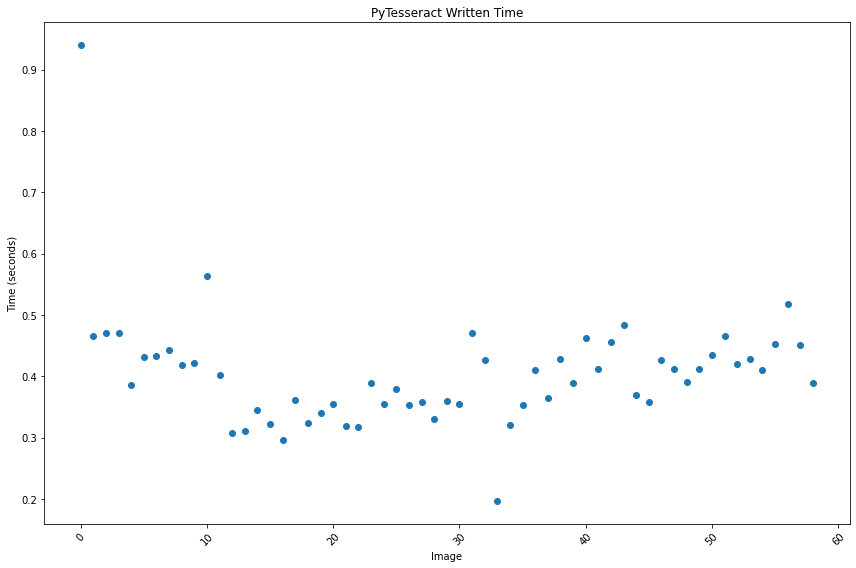

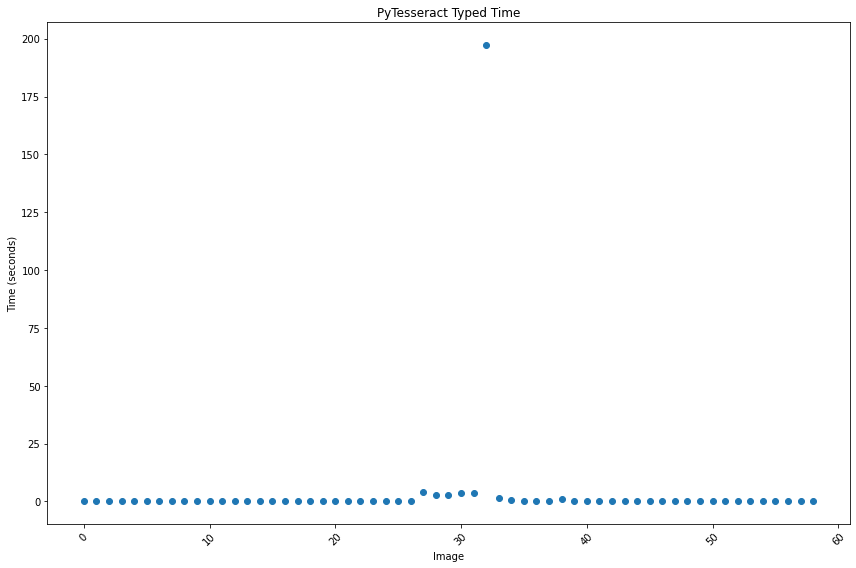

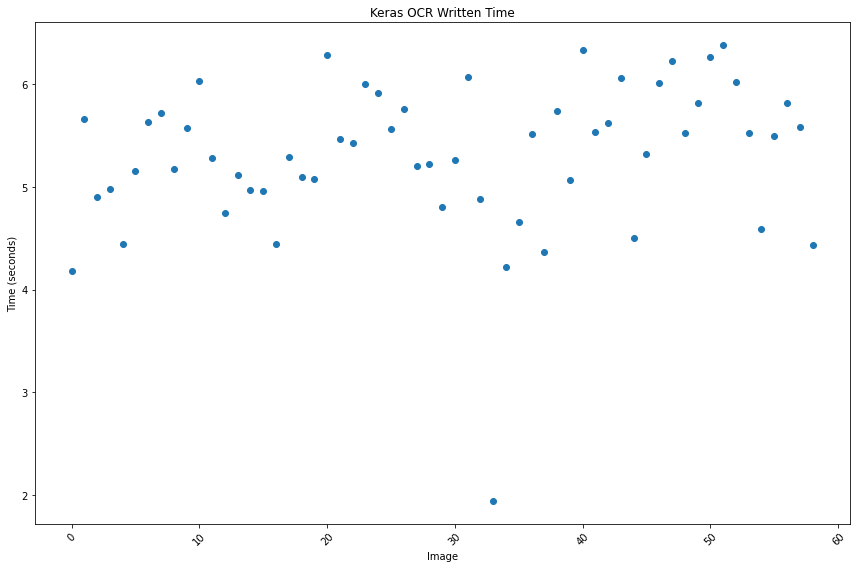

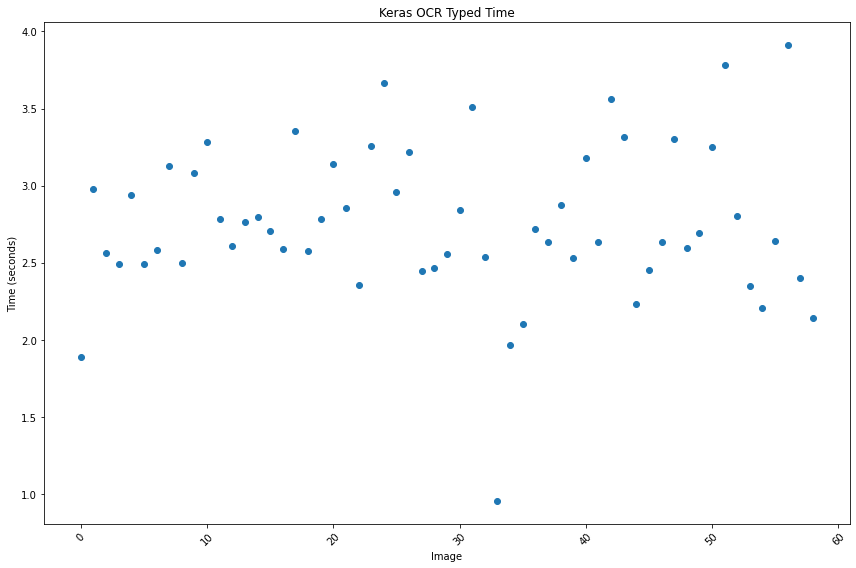

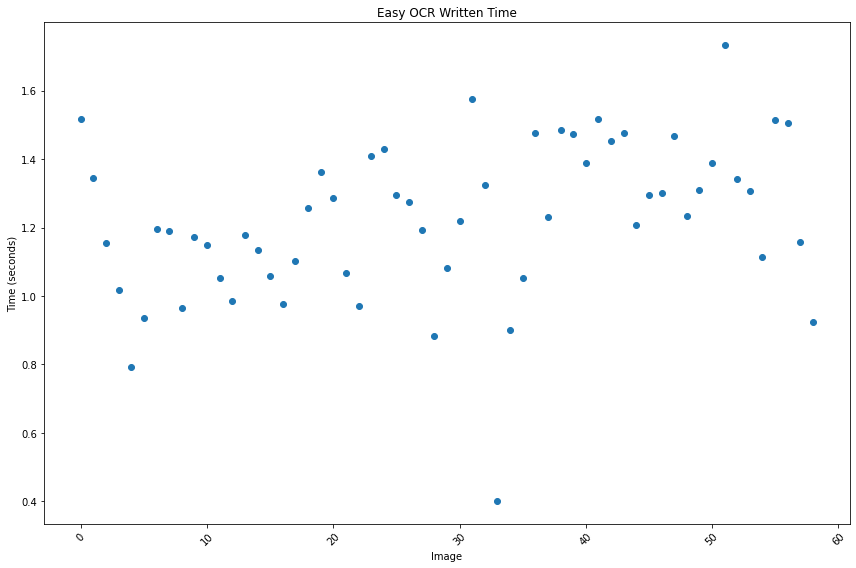

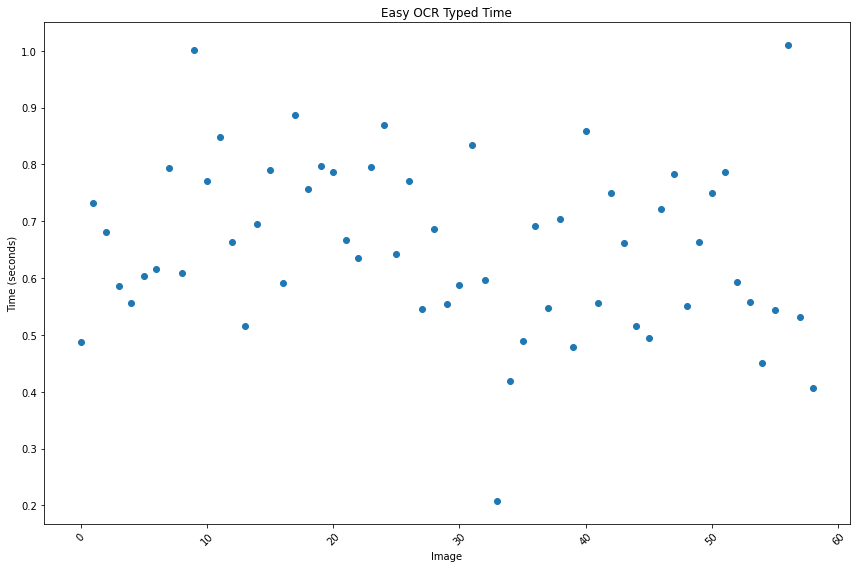

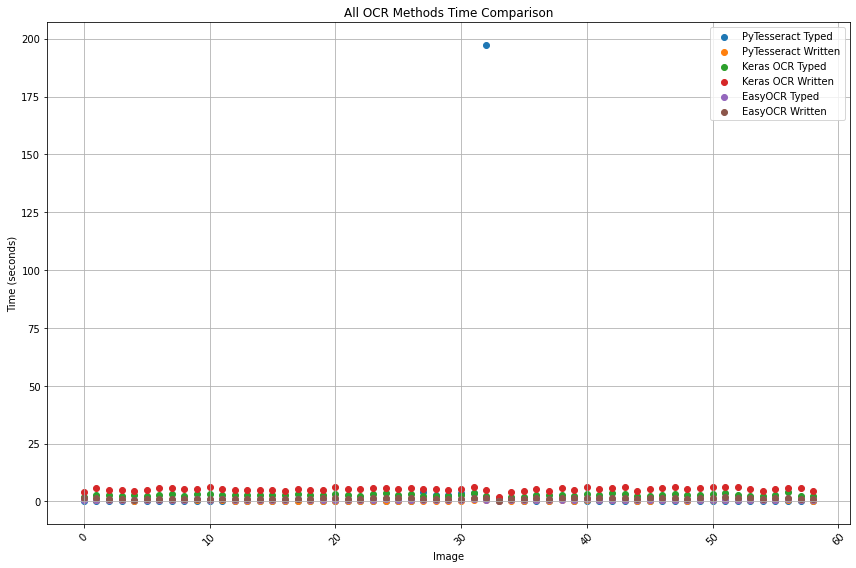

In [13]:
def plotTimes(times_dict, title):
    indices = range(len(times_dict))
    values = list(times_dict.values())
    plt.figure(figsize=(12, 8))
    plt.scatter(indices, values)
    plt.xlabel('Image')
    plt.ylabel('Time (seconds)')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plotAllTimes(lists, legend):
    plt.figure(figsize=(12, 8))
    for times_dict in lists:
        indices = range(len(times_dict))
        values = list(times_dict.values())
        plt.scatter(indices, values)
    plt.xlabel('Image')
    plt.ylabel('Time (seconds)')
    plt.title("All OCR Methods Time Comparison")
    plt.legend(legend, loc='upper right')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plotTimes(pyTesseractWrittenTime, "PyTesseract Written Time")
plotTimes(pyTesseractTypedTime, "PyTesseract Typed Time")
plotTimes(kerasWrittenTime, "Keras OCR Written Time")
plotTimes(kerasTypedTime, "Keras OCR Typed Time")
plotTimes(easyWrittenTime, "Easy OCR Written Time")
plotTimes(easyTypedTime, "Easy OCR Typed Time")

time_dicts = [pyTesseractTypedTime, pyTesseractWrittenTime, 
              kerasTypedTime, kerasWrittenTime,
              easyTypedTime, easyWrittenTime]

titles = ['PyTesseract Typed', 'PyTesseract Written',
          'Keras OCR Typed', 'Keras OCR Written',
          'EasyOCR Typed', 'EasyOCR Written']

plotAllTimes(time_dicts, titles)

In [14]:
#Clean data
#print("Processing images in directory (PyTesseract):", imageWritten)
#pyTesseractWrittenTime= processImagesPyTesseract(imageWritten, "pyWrittenCleaned", True)
#print("\nProcessing images in directory  (PyTesseract):", imageTyped)
#pyTesseractTypedTime=processImagesPyTesseract(imageTyped, "pyTypedCleaned", True)
#
#print("Processing images in directory (Keras OCR):", imageWritten)
#kerasWrittenTimeClean=processImagesKerasOcr(imageWritten, "kerasWrittenCleaned", True)
#print("\nProcessing images in directory (Keras OCR):", imageTyped)
#kerasTypedTimeClean=processImagesKerasOcr(imageTyped, "kerasTypedCleaned", True)
#
#print("Processing images in directory (Easy OCR):", imageWritten)
#easyWrittenTime=processImagesEasyOcr(imageWritten, "easy-ocrWrittenCleaned", True)
#print("\nProcessing images in directory (Easy OCR):", imageTyped)
#easyTypedTime=processImagesEasyOcr(imageTyped, "easy-ocrTypedCleaned", True)


groundTruth = 'cleaned/000-truth'
pyTesseractOutputTypedCleaned = 'outputs/pyTypedCleaned'
pyTesseractOutputWrittenCleaned = 'outputs/pyWrittenCleaned'
kerasOCROutputTypedCleaned = 'outputs/kerasTypedCleaned'
kerasOCROutputWrittenCleaned = 'outputs/kerasWrittenCleaned'
easyOCROutputTypedCleaned = 'outputs/easy-ocrTypedCleaned'
easyOCROutputWrittenCleaned = 'outputs/easy-ocrWrittenCleaned'
result = loadDataAll(groundTruth, pyTesseractOutputTypedCleaned, pyTesseractOutputWrittenCleaned, kerasOCROutputTypedCleaned, kerasOCROutputWrittenCleaned, easyOCROutputTypedCleaned, easyOCROutputWrittenCleaned)


Text1: A NEOUS tee ctegy Mle Comet shell fora wainatiog any mie Latour lee Mewes te te ba eth at a eet of Lateaer MPa toast Me Micha Mest has pat deme a remdutea im the itpet mtad te dette barked by Me Wall Grafts MEP for SMa bee ste Ba beaange 
Text2: A MOVE to stop Mr. Gaitskell from nominating any more Labour Life Peers is to  be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down a resolution on the subject and he is to be backed by Mr. Will Griffiths, M P for  Manchester Exhchange.
Text1: A MOVE 40 aloe Mr Gabel from  wom OS ag Aa ORR Labore Ule. Ptors  w to BR maar aha edna, ah Laden MPa domorreno Mer, Michael Toot kas pale Aowm a veaatabicns co bea Quote aun WL eto Va backeA by Mer Win GalBiye , WP for Mancmades Cectange | 
Text2: A MOVE to stop Mr. Gaitskell from nominating any more Labour Life Peers is to  be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down a resolution on the subject and he is to be backed by Mr. Will Griffiths, M 

# Models

In [15]:
#PyTesseract
#Doesn't used a Deep learning model like EasyOCR

In [16]:
#Keras OCR
print(pipeline.detector.model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 basenet.slice1.0 (Conv2D)      (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 basenet.slice1.1 (BatchNormali  (None, None, None,   256        ['basenet.slice1.0[0][0]']       
 zation)                        64)                                                         

In [17]:
print(pipeline.recognizer.model.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 31, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 permute (Permute)              (None, 200, 31, 1)   0           ['input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 200, 31, 1)   0           ['permute[0][0]']                
                                                                                                  
 conv_1 (Conv2D)                (None, 200, 31, 64)  640         ['lambda[0][0]']           

In [18]:
#Easy OCR
model = reader.recognizer 
print(model)

DataParallel(
  (module): Model(
    (FeatureExtraction): VGG_FeatureExtractor(
      (ConvNet): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU(inplace=True)
        (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): ReLU(inplace=True)
        (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (9): ReLU(inplace=True)
        (10): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
        (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [19]:
for name, param in model.named_parameters():
    print(name, param.shape)

module.FeatureExtraction.ConvNet.0.weight torch.Size([32, 1, 3, 3])
module.FeatureExtraction.ConvNet.0.bias torch.Size([32])
module.FeatureExtraction.ConvNet.3.weight torch.Size([64, 32, 3, 3])
module.FeatureExtraction.ConvNet.3.bias torch.Size([64])
module.FeatureExtraction.ConvNet.6.weight torch.Size([128, 64, 3, 3])
module.FeatureExtraction.ConvNet.6.bias torch.Size([128])
module.FeatureExtraction.ConvNet.8.weight torch.Size([128, 128, 3, 3])
module.FeatureExtraction.ConvNet.8.bias torch.Size([128])
module.FeatureExtraction.ConvNet.11.weight torch.Size([256, 128, 3, 3])
module.FeatureExtraction.ConvNet.12.weight torch.Size([256])
module.FeatureExtraction.ConvNet.12.bias torch.Size([256])
module.FeatureExtraction.ConvNet.14.weight torch.Size([256, 256, 3, 3])
module.FeatureExtraction.ConvNet.15.weight torch.Size([256])
module.FeatureExtraction.ConvNet.15.bias torch.Size([256])
module.FeatureExtraction.ConvNet.18.weight torch.Size([256, 256, 2, 2])
module.FeatureExtraction.ConvNet.18.

# Training Keras (with our dataset)

In [5]:
%pip install keras==2.10

  Attempting uninstall: keras
    Found existing installation: Keras 1.2.2
    Uninstalling Keras-1.2.2:
      Successfully uninstalled Keras-1.2.2Note: you may need to restart the kernel to use updated packages.



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-intel 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-gpu 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


In [10]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

# Paths to images and labels
image_folder = "cleaned/000-typed"
label_folder = "cleaned/000-truth"

# Function to load an image
def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    img = cv2.resize(img, (128, 32))  # Resize to (Width=128, Height=32)
    img = img / 255.0  # Normalize to [0,1]
    img = np.expand_dims(img, axis=-1)  # Add channel dimension (H, W, C)
    return img

# Function to read text label
def load_text(label_path):
    with open(label_path, "r", encoding="utf-8") as f:
        text = f.read().strip()
    return text

# Get list of images and corresponding labels
image_paths = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(".png")])
label_paths = sorted([os.path.join(label_folder, f) for f in os.listdir(label_folder) if f.endswith(".txt")])

# Load all images and labels
images = np.array([load_image(p) for p in image_paths])
texts = [load_text(p) for p in label_paths]

print("Loaded", len(images), "images and", len(texts), "labels")


Loaded 59 images and 59 labels


In [12]:
# Create a character-level tokenizer
tokenizer = Tokenizer(char_level=True, filters=None)  # Keeps all characters
tokenizer.fit_on_texts(texts)

# Convert words to sequences of numbers
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences to the max label length
max_label_length = max(len(seq) for seq in sequences)
padded_sequences = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_label_length, padding="post")

# Convert to numpy arrays
y_train = np.array(padded_sequences)

print("Vocabulary size:", len(tokenizer.word_index))
print("Max label length:", max_label_length)


Vocabulary size: 50
Max label length: 599


In [13]:
from tensorflow.keras import layers

# Input shape (Height=32, Width=128, Channels=1)
input_shape = (32, 128, 1)

# CNN Feature Extractor
inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)

# Reshape for RNN (Time Steps, Features)
x = layers.Reshape(target_shape=(32, -1))(x)  # Convert to (Time Steps, Features)

# RNN Layers (LSTM for sequence learning)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)

# Fully Connected Layer
x = layers.Dense(len(tokenizer.word_index) + 1, activation="softmax")(x)  # Output: vocabulary size + 1 (for blank)

# Define the Model
model = keras.Model(inputs, x)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

In [14]:
# CTC Loss function
def ctc_loss(y_true, y_pred):
    label_length = tf.reduce_sum(tf.ones_like(y_true), axis=1)  # Length of each label
    input_length = tf.reduce_sum(tf.ones_like(y_pred), axis=1)  # Length of each input sequence
    return keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

# Compile the model
model.compile(optimizer="adam", loss=ctc_loss)


In [ ]:
# Train the model
model.fit(images, y_train, epochs=10, batch_size=16, validation_split=0.1)


[[[[0.98823529]
   [0.98823529]
   [0.98039216]
   ...
   [0.97254902]
   [0.97647059]
   [0.98039216]]

  [[0.98039216]
   [0.98039216]
   [0.91372549]
   ...
   [0.94901961]
   [0.97647059]
   [0.98039216]]

  [[0.98039216]
   [0.98039216]
   [0.43529412]
   ...
   [0.49803922]
   [0.96862745]
   [0.97647059]]

  ...

  [[0.98039216]
   [0.93333333]
   [0.79215686]
   ...
   [0.98431373]
   [0.98431373]
   [0.98431373]]

  [[0.98431373]
   [0.97647059]
   [0.97254902]
   ...
   [0.98039216]
   [0.98431373]
   [0.98039216]]

  [[0.98431373]
   [0.98039216]
   [0.98039216]
   ...
   [0.98431373]
   [0.98431373]
   [0.98039216]]]


 [[[0.99607843]
   [0.98431373]
   [0.98823529]
   ...
   [0.98431373]
   [0.98039216]
   [0.98431373]]

  [[0.98431373]
   [0.94509804]
   [0.6745098 ]
   ...
   [0.98039216]
   [0.98431373]
   [0.98431373]]

  [[0.98431373]
   [0.83137255]
   [0.21960784]
   ...
   [0.98431373]
   [0.98431373]
   [0.98431373]]

  ...

  [[0.98431373]
   [0.98431373]
   [0.5

ValueError: in user code:

    File "c:\Users\adam4\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\adam4\AppData\Local\Temp\ipykernel_22644\415795996.py", line 5, in ctc_loss  *
        return keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    File "c:\Users\adam4\anaconda3\lib\site-packages\keras\backend.py", line 7010, in ctc_batch_cost
        input_length = tf.cast(tf.squeeze(input_length, axis=-1), tf.int32)

    ValueError: Can not squeeze dim[1], expected a dimension of 1, got 51 for '{{node ctc_loss/Squeeze_1}} = Squeeze[T=DT_FLOAT, squeeze_dims=[-1]](ctc_loss/Sum_1)' with input shapes: [?,51].


### Setup Functions

In [11]:
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import keras_ocr
import cv2
import numpy as np
import os

def matchData(imageFolder, groundTruthFolder):
    imagesPath = []
    textsPath = []
    #Assumes they are in the same order in both and each exists in the other
    for image in os.listdir(imageFolder):
        imagesPath.append(imageFolder + "/" +image)
    for text in os.listdir(groundTruthFolder):
        textsPath.append(groundTruthFolder+"/" + text)
    return imagesPath, textsPath

def loadImages(path, reSize = (535,100)): #REMEBER TO SIZE IMAGE AS NEEDED (had 128,32)
    images = []
    for image in path:
        img = (keras_ocr.tools.read(image))
        img = cv2.resize(img,reSize)
        images.append(img)
    return np.array(images) 

def loadText(path):
    labels = []
    for textPath in path:
        temp = openCalculate(textPath)
        temp = temp.replace("\n", "")
        labels.append(temp)
    print(labels)
    return np.array(labels)

def preprocess_labels(labels): #GPT
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)  # Convert text labels to numerical values
    encoded_labels = to_categorical(encoded_labels)  # One-hot encode labels
    return np.array(encoded_labels, dtype=np.float32)

testWritten = "cleaned/000-written-test"
testTyped = "cleaned/000-typed-test"
testTruth = "cleaned/000-typed-test"
trainWritten = "cleaned/000-written"
trainTyped = "cleaned/000-typed"
trainTruth = "cleaned/000-truth"

# two different models
#writtenTrainingData = list(zip(trainWrittenPath,trainTestPathW))
#typedTrainingData = list(zip(trainTypedPath, trainTestPathT))

trainWrittenPath, trainTestPathW = matchData("cleaned/000-written", "cleaned/000-truth")
trainTypedPath, trainTestPathT = matchData("cleaned/000-typed", "cleaned/000-truth")

### Detector Training

In [22]:
import keras_ocr
import numpy as np
from tensorflow.keras.optimizers import Adam

def trainDetector(trainWrittenPath):
    # Initialize the detector model
    detector = keras_ocr.detection.Detector()
    newModelD = detector.model
    newModelD.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')

    # Load and train on handwritten images
    images = loadImages(trainWrittenPath, reSize=(640, 640))
    sample_input = np.expand_dims(images[0], axis=0)
    sample_output = newModelD(sample_input)

    # Print input and output shapes for debugging
    print(f"Detector model input shape: {newModelD.input_shape}")
    print(f"Detector model output shape: {newModelD.output_shape}")

    # Generate dummy labels for the detector model with the correct shape
    detector_output_shape = sample_output.shape[1:]  # Exclude the batch size
    detector_labels = np.ones((len(images), *detector_output_shape))  # Adjust shape to match model output

    print(f"Number of images: {len(images)}")

    # Train the detector model on handwritten data
    newModelD.fit(images, detector_labels, epochs=10, batch_size=8)
    newModelD.save("nameDectector.h5")


### Recognizer Training

In [23]:
import keras_ocr
from tensorflow.keras.optimizers import Adam
from PIL import Image

def trainRecognizer(trainPath, groundTruthPath, name, batchSize, epochs):
    # Initialize the recognizer model
    images = [Image.open(imagePath) for imagePath in trainPath]
    texts = loadText(groundTruthPath)


    targetSize = (640, 640)
    images = [image.resize(targetSize) for image in images]


    images = [np.array(img) for img in images]
    images = np.array(images)

    recognizer = keras_ocr.recognition.Recognizer()
    
    trainingData = list(zip(images, texts))
    
    recognizer.fit(trainingData, batch_size=batchSize, epochs=epochs)

    recognizer.model.save(+"trained.h5")
    
    return recognizer


In [24]:
import keras_ocr
import numpy as np
import tensorflow as tf
from PIL import Image

def load_texts(text_paths):
    texts = []
    for text_path in text_paths:
        with open(text_path, 'r', encoding='utf-8') as f:
            texts.append(f.read().strip())
    return texts

def encode_texts(recognizer, texts, max_length=48):
    char_to_idx = {char: i + 1 for i, char in enumerate(recognizer.alphabet)}
    encoded_texts = []

    for text in texts:
        encoded = [char_to_idx.get(char, 0) for char in text]
        encoded = encoded[:max_length] + [0] * (max_length - len(encoded))
        encoded_texts.append(encoded)

    return np.array(encoded_texts)

def fine_tune_keras_ocr(image_paths, text_paths, batch_size, epochs):
    assert len(image_paths) == len(text_paths), "Mismatch between images and text files."

    target_size = (200, 31)
    images = [Image.open(img_path).convert("L").resize(target_size) for img_path in image_paths]
    images = np.array([np.array(img) for img in images]) / 255.0

    texts = load_texts(text_paths)
    recognizer = keras_ocr.recognition.Recognizer()
    labels = encode_texts(recognizer, texts)

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) #increased learning rate

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        for i in range(0, len(images), batch_size): #Corrected Batching
            batch_images = images[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            batch_image_paths = image_paths[i:i + batch_size]
            batch_texts = texts[i:i + batch_size]

            print(f"\nBatch {i // batch_size + 1}:")
            for img_path, text in zip(batch_image_paths, batch_texts):
                print(f"  Training on: {img_path} → Text: '{text}'")

            with tf.GradientTape() as tape:
                predictions = recognizer.model(batch_images, training=True)
                loss = tf.reduce_mean(loss_fn(batch_labels, predictions))

            gradients = tape.gradient(loss, recognizer.model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, recognizer.model.trainable_variables))
            print(f"  Batch Loss: {loss.numpy():.4f}")

    recognizer.model.save('fine_tuned_keras_ocr.h5')
    print("\nFine-tuning complete. Model saved as 'fine_tuned_keras_ocr.h5'.")

    return recognizer

# ... (Rest of your code for loading and testing)

### Using the Models

In [25]:
#need to finish
#trainPipeline('writtenModel', trainWrittenPath, trainTestPathW, epochs=10, batchSize=8)
#trainPipeline('typedModel', trainTypedPath, trainTestPathT, epochs=10, batchSize=8)

#trainWrittenPath, trainTestPathW 
#trainTypedPath, trainTestPathT
#
#trainDetector(trainWrittenPath)

#trainRecognizer(trainWrittenPath, trainTestPathW, 'written',8,10)
fine_tune_keras_ocr(trainWrittenPath, trainTestPathW, 4, 30)


Looking for C:\Users\adam4\.keras-ocr\crnn_kurapan.h5

Epoch 1/30

Batch 1:
  Training on: cleaned/000-written/a01-000.png → Text: 'A MOVE to stop Mr. Gaitskell from nominating any more Labour Life Peers is to 
be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down
a resolution on the subject and he is to be backed by Mr. Will Griffiths, M P for 
Manchester Exhchange.'
  Training on: cleaned/000-written/a01-003.png → Text: 'Through they may gather some Left-wing support, a large majority of Labour M Ps 
are likely to turn down the Foot-Griffiths resolution. Mr. Foot's line will be that as 
Labour M Ps opposed the Government Bill which brought life peers into existence, 
they should not now put forward nominees. He believes that the House of Lords 
should be abolished and that Labour should not take any steps which would appear 
to "prop-up" an out-dated institution.'
  Training on: cleaned/000-written/a01-007.png → Text: 'Since 1958, 13 Labour life Peers and Peeres

In [26]:
import keras_ocr
import tensorflow as tf

recognizer = keras_ocr.recognition.Recognizer()
recognizer.model.load_weights('fine_tuned_keras_ocr_weights.h5')
pipeline = keras_ocr.pipeline.Pipeline(recognizer=recognizer)
image_path = "cleaned/000-written-test/066-a06-000.png"
img = keras_ocr.tools.read(image_path)
result = pipeline.recognize([img])

for text in result[0]:
    print(text[0])  # text is a tuple of (text, box)

Looking for C:\Users\adam4\.keras-ocr\crnn_kurapan.h5
Looking for C:\Users\adam4\.keras-ocr\craft_mlt_25k.h5
2/2 [==============================] - 3s 852ms/step
ifufufuouofofif
ifofpfufopofofif
ifupoufufuofofufif
ifopfifouopouofufif
ifuopufupoupfofofif
ifufpopofuofif
ififopufufouofif
ifopfufufufoupofif
ifoufufufufofoufofif
ifufofefopuoufofofofif
ifoufafopououfofufofif
ififoftiuofofufufpf
ifspftfoufusoupofif
ififofofououofuofif
ifpfofosuouopfufif
ifumofufufufofofofif
ififupufufuopofofif
ifoufufufofofofif
ifufpufououfofif
ifofofsououfofif
ifofifpufufoufofif
ifupufufuopuofofif
ifofiufouofufofofif
ifoupufupofoufif
ifufpufufuofouofif
ifpuifuofoufofofif
ifpufufuououfif
ifsfefuopofif
ifopofouofif
ifouefuououfofofif
ififopupfopofofif
ifufuofofufofif
ififiuoupufufuofofif
ifofuoupotfofofif
ifofufofofofif
ifpfupouofofif
ififufufofopfofif
ifufufuouofif
ifofoufufufuopofofif
ifefufufopofofofif
ififpoifpoupopouofufpf
ifpfufofoufif
ifofofufofofif
ifoufufouofofif
ifupufufufuoufofif
ifopfpfofofiofufofi

In [27]:
import keras_ocr
detector = keras_ocr.detection.Detector()
recognizer = keras_ocr.recognition.Recognizer()

Looking for C:\Users\adam4\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\adam4\.keras-ocr\crnn_kurapan.h5


In [28]:
import cv2
import numpy as np

def train_keras_ocr(image_paths, text_paths, batch_size=8, epochs=10):
    
    images = [cv2.imread(img_path) for img_path in image_paths]
    texts = []
    for text_path in text_paths:
        with open(text_path, 'r', encoding='utf-8') as f:
            texts.append(f.read().strip())

    # Convert images to RGB
    images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]
    
    target_size = (640, 640)
    images = [cv2.resize(img, target_size) for img in images]

    images = np.array(images)

    recognizer = keras_ocr.recognition.Recognizer()

    training_data = list(zip(images, texts))

    recognizer.fit(training_data, batch_size=batch_size, epochs=epochs)

    recognizer.model.save('keras_ocr_trained_model.h5')

    print("Training complete. Model saved as 'keras_ocr_trained_model.h5'.")

    return recognizer


In [29]:
trained_model = train_keras_ocr(trainWrittenPath, trainTestPathW )


Looking for C:\Users\adam4\.keras-ocr\crnn_kurapan.h5


AttributeError: 'Recognizer' object has no attribute 'fit'

In [30]:
import keras_ocr

pipeline = keras_ocr.pipeline.Pipeline()

imagePath1 ="cleaned/000-written/a01-000.png"
imagePath2 = "cleaned/000-typed/a01-000.png"
def inferenceImage(image_path):
    images = [keras_ocr.tools.read(image_path)]

    # Perform OCR
    predictions = pipeline.recognize(images)

    for text, box in predictions[0]:  
        print(f"Detected text: {text}, Bounding box: {box}")

inferenceImage(imagePath2)


Looking for C:\Users\adam4\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\adam4\.keras-ocr\crnn_kurapan.h5
2/2 [==============================] - 3s 622ms/step
Detected text: life, Bounding box: [[425.   0.]
 [446.   0.]
 [446.  11.]
 [425.  11.]]
Detected text: labour, Bounding box: [[376.   0.]
 [421.   0.]
 [421.  11.]
 [376.  11.]]
Detected text: peers, Bounding box: [[449.   0.]
 [483.   0.]
 [483.  11.]
 [449.  11.]]
Detected text: is, Bounding box: [[487.   0.]
 [498.   0.]
 [498.  10.]
 [487.  10.]]
Detected text: gaitskell, Bounding box: [[150.   1.]
 [204.   1.]
 [204.  12.]
 [150.  12.]]
Detected text: from, Bounding box: [[207.   1.]
 [237.   1.]
 [237.  12.]
 [207.  12.]]
Detected text: nominating, Bounding box: [[240.21935    -0.7993772]
 [311.3711      1.495841 ]
 [310.9605     14.224531 ]
 [239.80876    11.929313 ]]
Detected text: to, Bounding box: [[502.   1.]
 [515.   1.]
 [515.  10.]
 [502.  10.]]
Detected text: move, Bounding box: [[22.  2.]
 [66.  2.]
 [66. 14.]


In [31]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from torch import ctc_loss

# Custom OCR model
def build_ocr_model(input_shape, num_classes):
    # Input layer
    input_img = Input(shape=input_shape, name="image_input")
    
    # CNN layers for feature extraction
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # RNN layers (using Bidirectional LSTM)
    x = Reshape((-1, 128))(x) 
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Dropout(0.25)(x)
    x = LSTM(256, return_sequences=True)(x)
    
    output = Dense(num_classes, activation='linear')(x)
    model = Model(inputs=input_img, outputs=output)
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


# height, width, channels
input_shape = (256, 512, 1)  

# number of characters in your vocabulary 
num_classes = 74

model = build_ocr_model(input_shape, num_classes)
model.summary()


Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 256, 512, 1)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 256, 512, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 256, 32)     0         
 )                                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 256, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 128, 64)      0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 128, 128)      738

In [32]:
import cv2
import numpy as np 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def resize_and_pad(image, target_height=256, target_width=512):
    h, w = image.shape[:2]
    aspect_ratio = w / h
    
    # Resize while maintaining the aspect ratio
    if aspect_ratio > 1:  # Wide image
        new_w = target_width
        new_h = int(target_width / aspect_ratio)
        # Ensure that the height doesn't exceed the target height
        if new_h > target_height:
            new_h = target_height
            new_w = int(target_height * aspect_ratio)
    else:  # Tall image
        new_h = target_height
        new_w = int(target_height * aspect_ratio)
        # Ensure that the width doesn't exceed the target width
        if new_w > target_width:
            new_w = target_width
            new_h = int(target_width / aspect_ratio)
    
    # Resize the image
    resized_img = cv2.resize(image, (new_w, new_h))
    
    # Create a new image with the target size, filled with zeros (black background)
    padded_img = np.zeros((target_height, target_width), dtype=np.float32)
    
    # Place the resized image in the center
    x_offset = (target_width - new_w) // 2
    y_offset = (target_height - new_h) // 2
    padded_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_img
    
    # Normalize to [0, 1]
    padded_img = padded_img / 255.0
    
    return padded_img

def load_images(image_paths, target_height=256, target_width=512):
    """
    Load and preprocess images: Resize and pad them to target dimensions.
    """
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image as grayscale
        img = resize_and_pad(img, target_height, target_width)  # Resize and pad image
        img = np.expand_dims(img, axis=-1)  # Add channel dimension (grayscale)
        images.append(img)
    
    return np.array(images)

def load_texts(directory_path):
    texts = []
    
    # List all files in the directory
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        if file_path.endswith('.txt'):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read().strip()  # Read and strip whitespace
                    texts.append(text)
            except Exception as e:
                print(f"Error reading file {file_path}: {e}")
    return texts

def prepare_labels(texts, max_length, num_classes):
    tokenizer = Tokenizer(char_level=True, lower=False)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    print(f"Max label value:{np.max(padded_sequences)}")
    return padded_sequences, tokenizer





In [33]:
from tensorflow.keras import backend as K


def train_ocr_model(model, train_images, train_texts, epochs, batch_size):
    model.fit(train_images, train_texts, batch_size=batch_size, epochs=epochs, validation_split=0.05)
    return model

train_images = np.array(load_images(trainWrittenPath))  # Ensure images are (32, 128, 1)
train_texts = np.array(load_texts("cleaned/000-truth"))  
allowed_chars = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789 .,-'\"!?" #add any other characters you want.
def filter_text(text):
    return "".join(char for char in text if char in allowed_chars)

filtered_texts = [filter_text(text) for text in train_texts]

max_text_length = 2048
train_texts, tokenizer = prepare_labels(train_texts, max_text_length, num_classes)
print(tokenizer.word_index)

trained_model = train_ocr_model(model, train_images, train_texts, epochs=30, batch_size=8)

Max label value:73
{' ': 1, 'e': 2, 't': 3, 'a': 4, 'o': 5, 'i': 6, 'n': 7, 'r': 8, 's': 9, 'h': 10, 'd': 11, 'l': 12, 'c': 13, 'u': 14, 'm': 15, 'f': 16, 'p': 17, '.': 18, 'g': 19, 'y': 20, 'b': 21, 'w': 22, '\n': 23, 'v': 24, ',': 25, 'M': 26, 'k': 27, '-': 28, 'S': 29, 'T': 30, '"': 31, 'P': 32, 'G': 33, 'A': 34, 'H': 35, 'L': 36, 'R': 37, 'B': 38, 'W': 39, "'": 40, 'N': 41, 'E': 42, 'C': 43, 'F': 44, 'I': 45, '0': 46, 'D': 47, 'j': 48, 'x': 49, 'q': 50, 'O': 51, 'K': 52, '1': 53, 'U': 54, '2': 55, '5': 56, '9': 57, 'V': 58, '8': 59, ':': 60, ';': 61, '3': 62, '4': 63, 'Y': 64, '7': 65, '6': 66, 'z': 67, '(': 68, ')': 69, 'J': 70, '*': 71, '¿': 72, '!': 73}
Epoch 1/30
7/7 [==============================] - 73s 11s/step - loss: 3.5615 - accuracy: 0.6930 - val_loss: 2.7497 - val_accuracy: 0.8034
Epoch 2/30
7/7 [==============================] - 82s 12s/step - loss: 2.8346 - accuracy: 0.8056 - val_loss: 3.0050 - val_accuracy: 0.8034
Epoch 3/30
7/7 [==============================] - 81s

KeyboardInterrupt: 

# Generating Words Using RNN

In [10]:
# Importing Libraries
import os
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from timeit import default_timer as timer
import cv2
import pytesseract
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader,random_split
from torchvision import transforms, datasets

In [17]:
dataPath = Path("Custom")
transformers = [transforms.Grayscale(num_output_channels = 1),transforms.Resize((128,128)),transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]
imageTransforms = transforms.Compose(transformers)
imageTransforms

trainingData = datasets.ImageFolder(root = dataPath,transform = imageTransforms,target_transform = None)
trainingData

Dataset ImageFolder
    Number of datapoints: 59
    Root location: Custom
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [18]:
validSize = int(0.2 * len(trainingData))  # 20%  
trainSize = len(trainingData) - validSize # 80%
train_subset, val_subset = random_split(trainingData, [trainSize, validSize])
train_dataloader = DataLoader(dataset = train_subset, batch_size = 32, shuffle=True,)
val_dataloader = DataLoader(dataset = val_subset, batch_size = 32, shuffle = False,)
train_dataloader , val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1e722b7cd00>,
 <torch.utils.data.dataloader.DataLoader at 0x1e72245d0a0>)

In [19]:
class HandWritingRNN(nn.Module):
    def __init__(self, inputShape, hiddenUnits, outputShape, numLayers = 1):
        super(HandWritingRNN,self).__init__()
        self.hidden_units = hiddenUnits
        self.num_layers = numLayers
        self.RNN = nn.LSTM(inputShape, hiddenUnits, numLayers,batch_first = True) #maybe write self.lstm 
        self.fc = nn.Linear(hiddenUnits,outputShape)
        
    def forward(self,x,hidden):
        out,hidden = self.RNN(x,hidden) #if changed ^ then something self.lstm(x)
        out = self.FC(out) #if changed & then self.fc(out[:,-1:]) take last timestep out
        return out,hidden
    
    def init_hidden(self,batch_size,device):
        return (torch.zeros(self.num_layers,batch_size,self.hidden_units,device = device),
               torch.zeros(self.num_layers,batch_size,self.hidden_units,device = device))

In [ ]:
def train_step(model =torch.nn.Module, dataloader = torch.utils.data.DataLoader, lossFunction = torch.nn.Module,optimizer = torch.optim.Optimizer, device = torch.device):
    model.train()
    train_loss = 0.0 
    
    for X,_ in dataloader:
        X = X.to(device)
        
        batch_size,channels,height,width = X.size()
        X = X.view(batch_size,-1) # Flatting  (IS IT SUPPOSED OT BE )
        X = X.unsqueeze(1) # Adding Sequence Dimension
        
        hidden = model.init_hidden(X.size(0),device)
        
        optimizer.zero_grad()
        
        outputs, _ = model(X,hidden)
        
        outputs = outputs.squeeze(1) 
        targets = X.view(X.size(0),-1) # flatting the targets
        
        loss = lossFunction(outputs , targets)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    return train_loss / len(dataloader)

In [15]:
def test_step(model : torch.nn.Module,
             dataloader : torch.utils.data.DataLoader,
             loss_fn : torch.nn.Module,
             device = torch.device):
    model.eval()
    test_loss = 0.0 
    with torch.inference_mode():
        for X,_ in dataloader:
            X = X.to(device)
            
            batch_size,channels,height,width = X.size()
            X = X.view(batch_size,-1)
            X = X.unsqueeze(1)
            
            hidden = model.init_hidden(X.size(0),device)
            
            outputs, _ = model(X, hidden)

            # Flatten outputs and targets
            outputs = outputs.squeeze(1)  # Remove sequence dimension
            targets = X.view(X.size(0), -1)  # Flatten targets

            loss = loss_fn(outputs, targets)
            test_loss += loss.item()
    return test_loss / len(dataloader)

In [8]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          device: torch.device,
          epochs: int = 5):
    model.to(device)
    results = {"train_loss": [],
               "val_loss": []}
    
    for epoch in range(epochs):
        train_loss = train_step(model, train_dataloader, loss_fn, optimizer, device)
        val_loss = test_step(model, val_dataloader, loss_fn, device)
        
        print(f"Epoch: {epoch + 1} | train_loss: {train_loss:.3f} | val_loss: {val_loss:.3f}")
        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)
    
    return results


In [ ]:
#TO MUCH PROCESSING POWER Need  run on gpu

input_shape = 128*128
output_shape = input_shape
hidden_units = 256
num_layers = 2
model = HandWritingRNN(input_shape,output_shape, hidden_units, num_layers)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.005) 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

model_results = train(model, train_dataloader, val_dataloader, optimizer, loss_fn, epochs=15, device=device)

end_time = timer()

print(f"Total Training Time : {end_time - start_time:.3f}seconds")

KeyboardInterrupt: 

In [1]:
import torch.nn.functional as F
def sample(predictions, temperature=1.0):
    predictions = predictions / temperature
    probabilities = F.softmax(predictions, dim=-1)
    return torch.multinomial(probabilities, 1).item()

In [2]:
## Creating Preprocess_image to improve image quality before extracting text
def preprocess_image(image):
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    image_array = np.array(image)
    
    gray_image = cv2.cvtColor(image_array,cv2.COLOR_RGB2GRAY)
    
    _,thresh_image = cv2.threshold(gray_image,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return thresh_image

def extract_text_from_image(image):
    print(image)
    preprocessed_image = preprocess_image(image)
    pil_image = Image.fromarray(preprocessed_image)
    text = pytesseract.image_to_string(pil_image,config='--psm 11')
    return text.strip()

In [3]:
image_path_list = list(dataPath = Path("test_folder").glob("*/*"))
random_image_path = random.choice(image_path_list)
image = Image.open(random_image_path)

pytesseract.pytesseract.tesseract_cmd = "C:/Program Files/Tesseract-OCR/tesseract.exe"

extracted_text = extract_text_from_image(image)
print(f"Extracted Image : {extracted_text}")

NameError: name 'Path' is not defined

In [8]:
import torch.nn.functional as F
def generate_text(model, seed_text, max_length, device, temperature=1.0):
    model.eval()
    generated_text = seed_text
    
    # Converting Textv into tensor
    seed_tensor = torch.tensor([ord(char) for char in seed_text], dtype=torch.float32).unsqueeze(0).to(device)

    if seed_tensor.size(-1) < 16384:
        padding_size = 16384 - seed_tensor.size(-1)
        seed_tensor = F.pad(seed_tensor, (0, padding_size), 'constant', 0)
    else:
        seed_tensor = seed_tensor[:, :16384]
    
    seed_tensor = seed_tensor.unsqueeze(1)  

    hidden = model.init_hidden(seed_tensor.size(0), device)

    print(f"Initial seed_tensor shape: {seed_tensor.shape}")
    print(f"Initial Hidden state shape: {hidden[0].shape}, {hidden[1].shape}")

    with torch.no_grad():
        for _ in range(max_length):
            output, hidden = model(seed_tensor, hidden)

            output = output.squeeze(1) 
            predictions = output[-1] 

            predicted_char_index = sample(predictions, temperature)
            predicted_char = chr(predicted_char_index)
            generated_text += predicted_char

            # Update seed tensor with the new character
            new_char_tensor = torch.tensor([ord(predicted_char)], dtype=torch.float32).unsqueeze(0).to(device)
            new_char_tensor = F.pad(new_char_tensor, (0, 16384 - new_char_tensor.size(-1)), 'constant', 0)
            new_char_tensor = new_char_tensor.unsqueeze(1)

            # Slide the window to include the new character
            seed_tensor = torch.cat((seed_tensor[:, 1:, :], new_char_tensor), dim=1)

    return generated_text

In [9]:
seed_text = extracted_text
max_length = 200
temperature = 0.8
model.to(device)
generated_text = generate_text(model, seed_text, max_length, device)
print(f"Generated text: {generated_text}")

NameError: name 'extracted_text' is not defined